# Deep Learning Models  

Importing relevant libraries

In [12]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

#### Data Loading and Directory Setup

Loads training and test data for multiple stocks. The data is read from CSV files located in the specified `data_dir`, and the individual stock datasets are concatenated into unified training (`train_df`) and testing (`test_df`) DataFrames.

The models will be saved in the directory specified by `save_dir`.


In [ ]:
# Define directories for data and model saving
data_dir = '/home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/data/FIAP_PI'
save_dir = "/home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models"
stocks = ['BBAS3.SA', 'CSNA3.SA', 'PETR4.SA', 'VALE3.SA'] 

# Initialize lists to store training and test DataFrames
train_dfs = []
test_dfs = []

# Load training and testing data for each stock
for stock in stocks:
    stock_dir = os.path.join(data_dir, stock)
    train_stock_df = pd.read_csv(f"{stock_dir}/treino.csv", index_col=0)
    test_stock_df = pd.read_csv(f"{stock_dir}/teste.csv", index_col=0)
    
    # Append DataFrames to respective lists
    train_dfs.append(train_stock_df)
    test_dfs.append(test_stock_df)

# Concatenate all training and testing DataFrames
train_df = pd.concat(train_dfs, ignore_index=False)
test_df = pd.concat(test_dfs, ignore_index=False)


Label adjustment.

In [ ]:
# Replace -1 with 0 in the fourth column (label column) for train_df and test_df
train_df.iloc[:, 3] = train_df.iloc[:, 3].replace(-1, 0)
test_df.iloc[:, 3] = test_df.iloc[:, 3].replace(-1, 0)

# Apply the same transformation to each individual DataFrame in test_dfs
for df in test_dfs:
    df.iloc[:, 3] = df.iloc[:, 3].replace(-1, 0)


Feature reshaping for model input.

In [ ]:
# Extract features and labels from train_df
train_features = train_df.iloc[:, 4:].values  # Shape: (n_samples, 15)
labels = train_df.iloc[:, 3].values          # Shape: (n_samples,)

# Reshape the feature matrix to (samples, timesteps, features)
train_features = train_features.reshape((train_features.shape[0], train_features.shape[1], 1))


Define history ploting method.

In [5]:
def plot_training_history(history):
    """
    Plots training & validation accuracy and loss from a Keras model history.

    Parameters:
    history : keras.callbacks.History
        The history object returned by model_cnn.fit()
    """
    history_dict = history.history

    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history_dict['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.grid()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history_dict['loss'], label='Training Loss', color='blue')
    plt.plot(history_dict['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.grid()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

Defines EarlyStopping and ModelCheckpoint callbacks and a method to save a model. 

In [ ]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=15,          # Stop training if val_loss doesn't improve for 10 epochs
    restore_best_weights=True,  # Restore the best model weights after stopping
    verbose=1
)

# Define ModelCheckpoint callback
def save_best_model(model_name, save_dir):

    # Ensure the directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Define full save path
    save_path = os.path.join(save_dir, f"best_{model_name}.keras")

    checkpoint = ModelCheckpoint(
        filepath=save_path,  # Saves model as "best_cnn.h5" or "best_lstm.h5"
        monitor="val_loss",   # Track validation loss
        save_best_only=True,  # Save only the best model
        verbose=1             # Print when a model is saved
    )
    return checkpoint

def save_last_model(model, model_name, save_dir):

    # Ensure the directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Define full save path
    save_path = os.path.join(save_dir, f"last_{model_name}_{model.name}.keras")

    # Save the model
    model.save(save_path)

    print(f"Last model saved to: {save_path}")

Defines save directory for each model.

In [7]:
save_dir_lstm=f"{save_dir}/lstm"
save_dir_cnn=f"{save_dir}/cnn"

## Models

### LSTM  Model.

In [9]:
# Define the model
model_lstm = Sequential([
    Input(shape=(15, 1)),   # Explicit Input layer
    LSTM(64),               # LSTM layer with 64 units
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model with binary crossentropy loss and Adam optimizer
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model_lstm.summary()

lstm_checkpoint = save_best_model(f"lstm_{model_lstm.name}", save_dir_lstm)

# Fit model
history_lstm = model_lstm.fit(
    train_features, labels,
    epochs=200, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stopping, lstm_checkpoint] 
)

save_last_model(model_lstm, "lstm", save_dir_lstm)

I0000 00:00:1739985714.095403  904930 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1739985714.119355  904930 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1739985714.122060  904930 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1739985714.124900  904930 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


2025-02-19 14:21:55.294196: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


476/478 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5586 - loss: 0.6872
Epoch 1: val_loss improved from inf to 0.68361, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/lstm/best_lstm_sequential.keras
478/478 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5586 - loss: 0.6872 - val_accuracy: 0.5630 - val_loss: 0.6836
Epoch 2/200
461/478 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5713 - loss: 0.6809
Epoch 2: val_loss improved from 0.68361 to 0.66275, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/lstm/best_lstm_sequential.keras
478/478 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5718 - loss: 0.6807 - val_accuracy: 0.5638 - val_loss: 0.6628
Epoch 3/200
465/478 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6386 - loss: 0.6210
Epoch 3: val_loss improved from 0.66275 to 0.59488, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/lstm/best_lstm_sequential.keras
478/478 ━━━━━━━━━━━━━━━━━━

Plotting LSTM Model's training history.

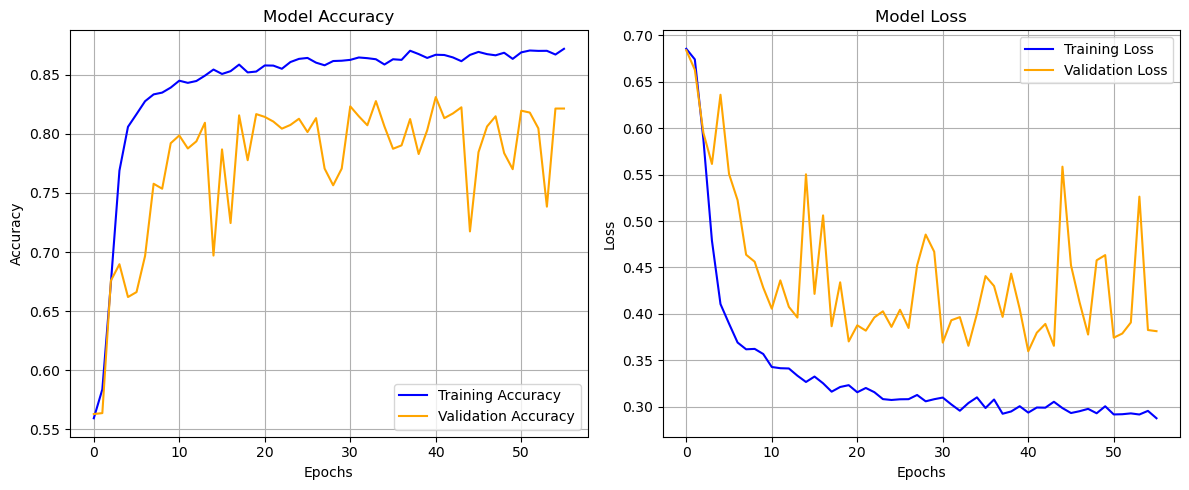

In [10]:
plot_training_history(history_lstm)

Evaluates LSTM Model for each stock.

Test results for stock: BBAS3.SA
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step
Accuracy: 0.66
Precision: 0.56
Recall: 0.87
F1 Score: 0.68
Confusion Matrix:


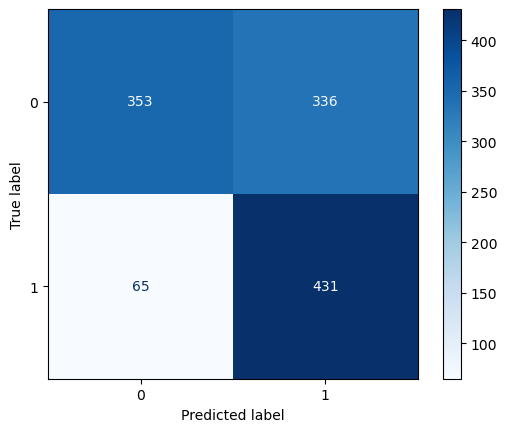


Test results for stock: CSNA3.SA
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
Accuracy: 0.82
Precision: 0.73
Recall: 0.91
F1 Score: 0.81
Confusion Matrix:


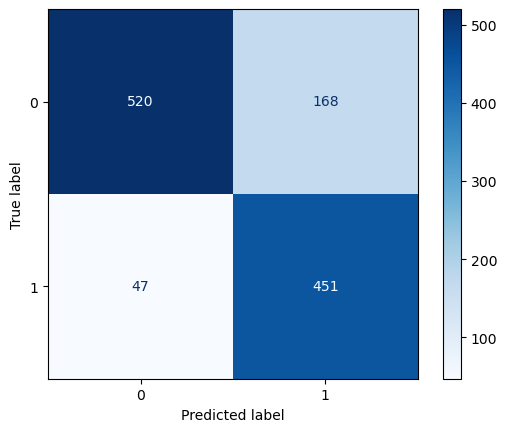


Test results for stock: PETR4.SA
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step
Accuracy: 0.84
Precision: 0.81
Recall: 0.89
F1 Score: 0.85
Confusion Matrix:


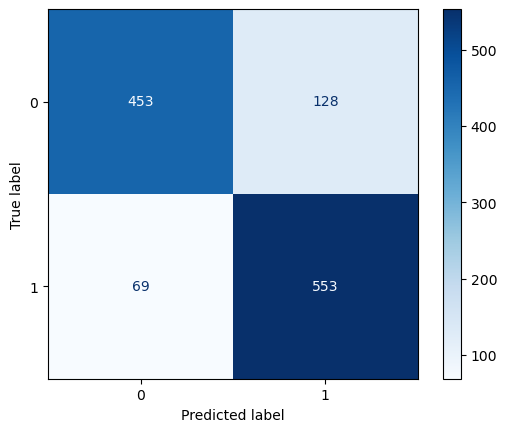


Test results for stock: VALE3.SA
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
Accuracy: 0.51
Precision: 0.51
Recall: 0.92
F1 Score: 0.65
Confusion Matrix:


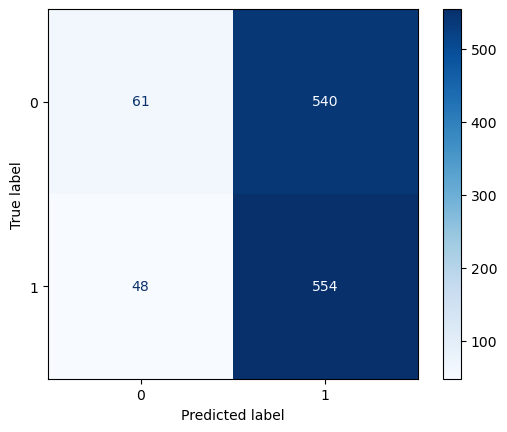

In [13]:
# Evaluate LSTM model on test data for each stock
for stock_name, stock_test_df in zip(stocks, test_dfs):
    X_test = stock_test_df.iloc[:, 4:].values
    y_test = stock_test_df.iloc[:, 3].values

    print(f"Test results for stock: {stock_name}")
    
    # Make predictions using the LSTM model
    y_pred_probs = model_lstm.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print the computed metrics
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Confusion Matrix:")
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    print()


### CNN1d  Model.

In [ ]:
# Define the model
model_cnn = Sequential([
    Input(shape=(15, 1)),                                   # Explicit Input layer
    Conv1D(filters=64, kernel_size=3, activation='relu'),   # 1D Convolutional layer
    MaxPooling1D(pool_size=2),                              # MaxPooling layer to reduce dimensionality
    Conv1D(filters=32, kernel_size=3, activation='relu'),   # Another Conv1D layer
    Flatten(),                                              # Flatten layer to transition from CNN to Dense
    Dense(64, activation='relu'),                           # Fully connected dense layer
    Dropout(0.3),                                           # Dropout to prevent overfitting
    Dense(1, activation='sigmoid')                          # Output layer for binary classification
])

# Compile the model with binary crossentropy loss and Adam optimizer
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model_cnn.summary()

cnn_checkpoint = save_best_model(f"cnn_{model_cnn.name}", save_dir_cnn)

# Fit the model
history_cnn = model_cnn.fit(
    train_features, labels,
    epochs=200, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stopping, cnn_checkpoint]  
)

save_last_model(model_cnn, "cnn", save_dir_cnn)

I0000 00:00:1739985240.449820  899690 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1739985240.473438  899690 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1739985240.476155  899690 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1739985240.479385  899690 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 13, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 4, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,753 (57.63 KB)

 Trainable params: 14,753 (57.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


I0000 00:00:1739985241.485026  900190 service.cc:146] XLA service 0x7178c0009d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739985241.485044  900190 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-02-19 14:14:01.498014: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-19 14:14:01.565264: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


289/478 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - accuracy: 0.5401 - loss: 0.6998

I0000 00:00:1739985242.537171  900190 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


478/478 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5505 - loss: 0.6928
Epoch 1: val_loss improved from inf to 0.60022, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/cnn/best_cnn_sequential.keras
478/478 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5505 - loss: 0.6928 - val_accuracy: 0.6130 - val_loss: 0.6002
Epoch 2/200
391/478 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - accuracy: 0.6329 - loss: 0.6334
Epoch 2: val_loss improved from 0.60022 to 0.58941, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/cnn/best_cnn_sequential.keras
478/478 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.6396 - loss: 0.6284 - val_accuracy: 0.7091 - val_loss: 0.5894
Epoch 3/200
457/478 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.7613 - loss: 0.5127
Epoch 3: val_loss improved from 0.58941 to 0.52747, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/cnn/best_cnn_sequential.keras
478/478 ━━━━━━━━━━━━━━━━━━

Plotting CNN1d Model's training history.

In [14]:
plot_training_history(history_cnn)

NameError: name 'history_cnn' is not defined

Evaluates CNN1d Model for each stock.

Test results for stock: BBAS3.SA
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
sequential
Accuracy: 0.88
Precision: 0.84
Recall: 0.87
F1 Score: 0.86
Confusion Matrix:


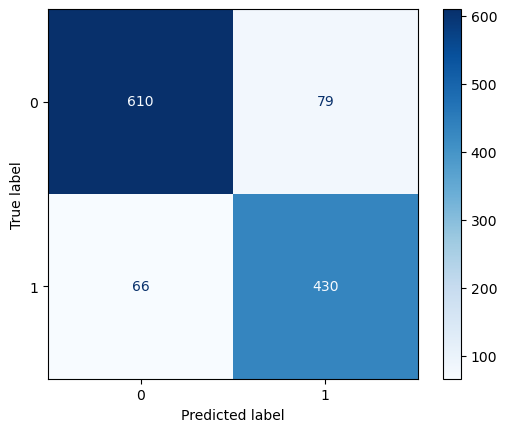


Test results for stock: CSNA3.SA
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
sequential
Accuracy: 0.88
Precision: 0.84
Recall: 0.89
F1 Score: 0.86
Confusion Matrix:


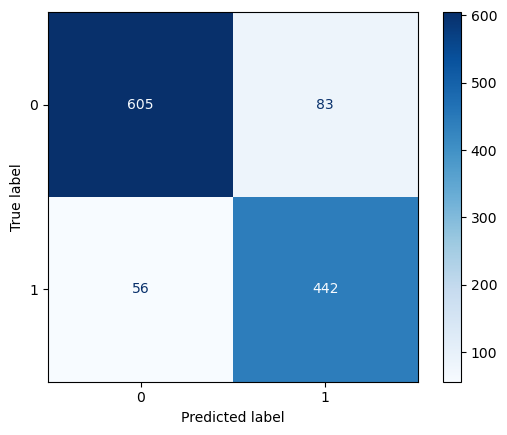


Test results for stock: PETR4.SA
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
sequential
Accuracy: 0.85
Precision: 0.86
Recall: 0.85
F1 Score: 0.85
Confusion Matrix:


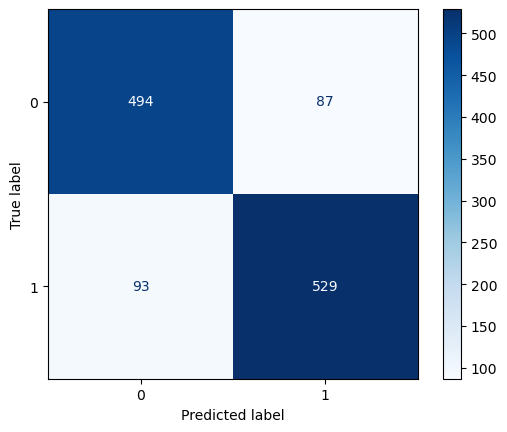


Test results for stock: VALE3.SA
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
sequential
Accuracy: 0.87
Precision: 0.87
Recall: 0.86
F1 Score: 0.86
Confusion Matrix:


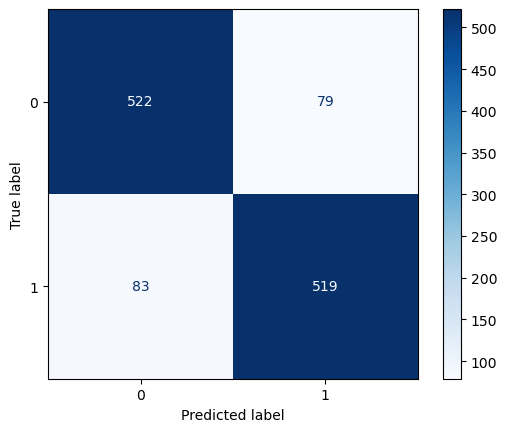

In [ ]:
for stock_name, stock_test_df in zip(stocks, test_dfs):
    X_test = stock_test_df.iloc[:, 4:].values
    y_test = stock_test_df.iloc[:, 3].values

    print(f"Test results for stock: {stock_name}")
    y_pred_probs = model_cnn.predict(X_test)
    print(model_cnn.name)
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print the metrics
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Confusion Matrix:")
    # print(conf_matrix)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap=plt.cm.Blues)  # Set colormap here
    plt.show()
    print()